In [9]:
%run data_preparation.ipynb

Accessible dataframes    Description                            # of columns  
combined_data            Gives combined data from 2015-2019     15
data_2020                Gives data for 2020                    15
data_2024                Gives data for 2024                    13
station_data             Existing stations in NYC from Lyft      6


In [ ]:
current_directory = os.getcwd()
file_name = "data/2020"
folder_path = os.path.join(current_directory, file_name)

data_2020 = combine_csv_files(folder_path)
data_2020.iloc[:3]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,146,2020-12-01 00:02:50.1450,2020-12-01 00:05:16.1940,3202,Newport PATH,40.727224,-74.033759,3199,Newport Pkwy,40.728745,-74.032108,42308,Subscriber,1989,2
1,572,2020-12-01 00:11:57.3910,2020-12-01 00:21:30.2510,3640,Journal Square,40.733670,-74.062500,3280,Astor Place,40.719282,-74.071262,18568,Subscriber,1997,2
2,387,2020-12-01 00:14:49.3610,2020-12-01 00:21:16.8730,3640,Journal Square,40.733670,-74.062500,3194,McGinley Square,40.725340,-74.067622,44543,Subscriber,1960,1


In [ ]:
data_2020['starttime'] = pd.to_datetime(data_2020['starttime'])
data_2020['stoptime'] = pd.to_datetime(data_2020['stoptime'])

# Reduce memory usage
cols = ['start station name', 'end station name', 'bikeid', 'usertype', 'gender']
for col in cols:
    data_2020[col] = data_2020[col].astype('category')

##### Ghost rides (taken from: https://towardsdatascience.com/interpolating-nyc-bike-share-data-to-discover-rebalancing-movements-6cf8a80eb902)

In [ ]:
offset = pd.DataFrame({'starttime': pd.to_datetime('2010-09-01'),\
  'start station id':0,'stoptime': pd.to_datetime('2010-09-01'),\
  'end station id':0,'bikeid':0},index=[0])

In [ ]:
dfbike1 = pd.concat([offset,data_2020]).reset_index(drop=True)
dfbike2 = pd.concat([data_2020,offset]).reset_index(drop=True)

dfbike=pd.concat ([dfbike1[['bikeid','stoptime','end station id']]\
            ,dfbike2[['bikeid','starttime','start station id']] ],\
             axis=1 )

In [ ]:
dfbike.columns=['bikeid1','starttime','start station id',\
                'bikeid2','stoptime','end station id']
dfrebal = dfbike[['starttime','start station id',\
                  'stoptime','end station id']].\
           loc[(dfbike.bikeid1==dfbike.bikeid2) & \
          (dfbike['start station id'] != dfbike['end station id']) ]
dfrebal.reset_index(drop=True, inplace=True)

In [ ]:
dfstations = combine_csv_files(folder_path)

In [ ]:
dfstations = dfstations[['start station id','start station name']] 
dfstations.columns=['station id','station name']
dfstations.drop_duplicates(inplace=True)
dfstations.set_index('station id',drop=True, inplace=True)
len(dfstations)

In [ ]:
dfrebal = pd.merge(dfrebal, dfstations[['station name']],\
     how = 'left', left_on='start station id', right_on='station id')
dfrebal = pd.merge(dfrebal, dfstations[['station name']],\
     how = 'left', left_on='end station id', right_on='station id')

In [ ]:
dfrebal.rename(columns = 
        {'station name_x':'start station name',\
         'station name_y':'end station name'},\
          inplace = True)

In [ ]:
dfrebal

,starttime,start station id,stoptime,end station id,start station name,end station name
0,2020-08-12 02:42:57.923,3205,2020-08-12 03:27:46.516,3279,JC Medical Center,Dixon Mills


In [ ]:
rebalin = dfrebal['end station name'].value_counts()[:20]
rebalout = dfrebal['start station name'].value_counts()[:20]

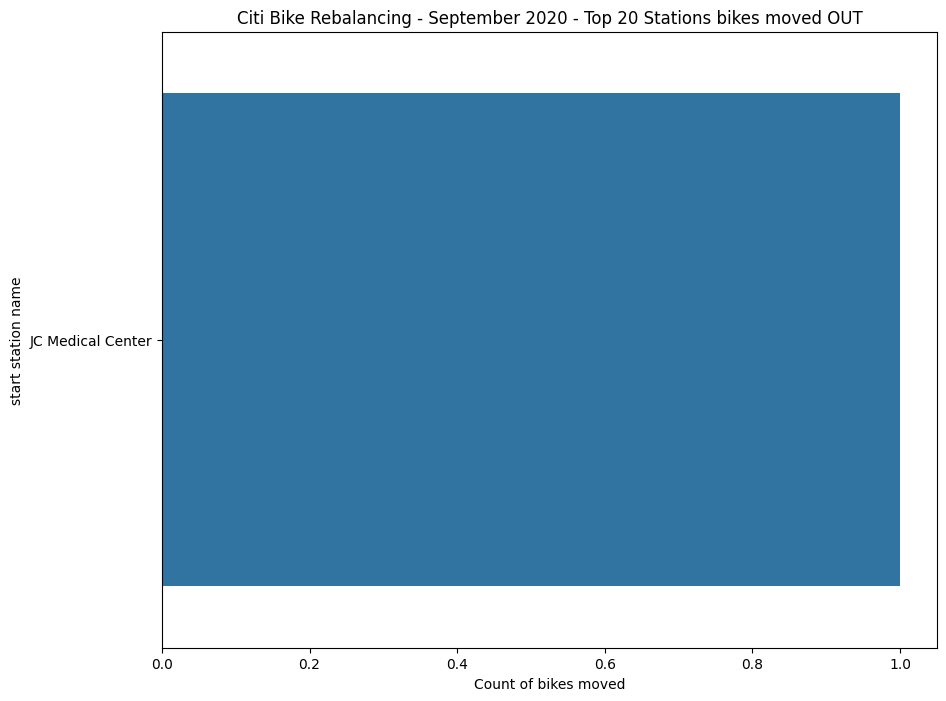

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Citi Bike Rebalancing - 2020\
 - Top 20 Stations bikes moved OUT'  ) 
plt.xlabel('Count of bikes moved') 
sns.barplot( x=rebalout.values, y=rebalout.index,  orient="h" ) ;

## Grouped stations

In [ ]:
# Group by start_station_id and started_at, and calculate count, start_lat, and start_lng for each group
grouped_data = data_2024.groupby(['start_station_name', 'started_at']).agg({
    'start_lat': 'first',
    'start_lng': 'first',
    'ride_id': 'count'  # Count the number of objects standing at each station at each time point
}).reset_index()

# Rename the 'ride_id' column to 'count' for clarity
grouped_data.rename(columns={'ride_id': 'count'}, inplace=True)

# Find the maximum count of objects standing at any given time for each station
max_objects_count = grouped_data.groupby('start_station_name')['count'].max()
max_objects_count

start_station_name
11 St & Washington St                2
12 St & Sinatra Dr N                 1
14 St Ferry - 14 St & Shipyard Ln    2
2 St & Park Ave                      2
4 St & Grand St                      1
                                    ..
Van Vorst Park                       2
Warren St                            2
Washington St                        1
Willow Ave & 12 St                   1
York St & Marin Blvd                 2
Name: count, Length: 89, dtype: int64

# HTML File with stations (Lyft)

In [4]:
# Sample data
locations = station_data['name']
latitudes = station_data['lat']
longitudes = station_data['lon']
sizes = station_data['capacity']
#values = [20, 30, 25, 40]  # Values for the color scale

# Initialize the map centered around the first location
mymap = folium.Map()

# Iterate over locations
for lat, lon, size, location in zip(latitudes, longitudes, sizes, locations):
    # Add circle marker with varying sizes
    folium.CircleMarker(
        location=[lat, lon],
        radius=size / 10,  # Normalize size for better visualization
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=location
    ).add_to(mymap)

# Save the map to an HTML file
mymap.save("nyc_bike_stations.html")